<a href="https://colab.research.google.com/github/Davidportlouis/fashion_mnist/blob/master/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## import required libraries
import time
import torch
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from helper import plot_batch,train,test,predict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [3]:
## data transformation (pre-processing)
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.5,),
                       std=(0.5,))
])

## downloading dataset (train & test set)
train_data = datasets.FashionMNIST(root="./",train=True,transform=transform,download=True)
test_data = datasets.FashionMNIST(root="./",train=False,transform=transform,download=True)

## splitting cross validation set
train_len = len(train_data)
idx = list(range(train_len))
np.random.shuffle(idx)
split = int(np.floor(0.2 * train_len))
valid_idx,train_idx = idx[:split],idx[split:]

## samplers
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

## dataloaders
trainloader = torch.utils.data.DataLoader(train_data,batch_size=20,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data,batch_size=20,sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data,batch_size=20,shuffle=True)

classes = train_data.classes

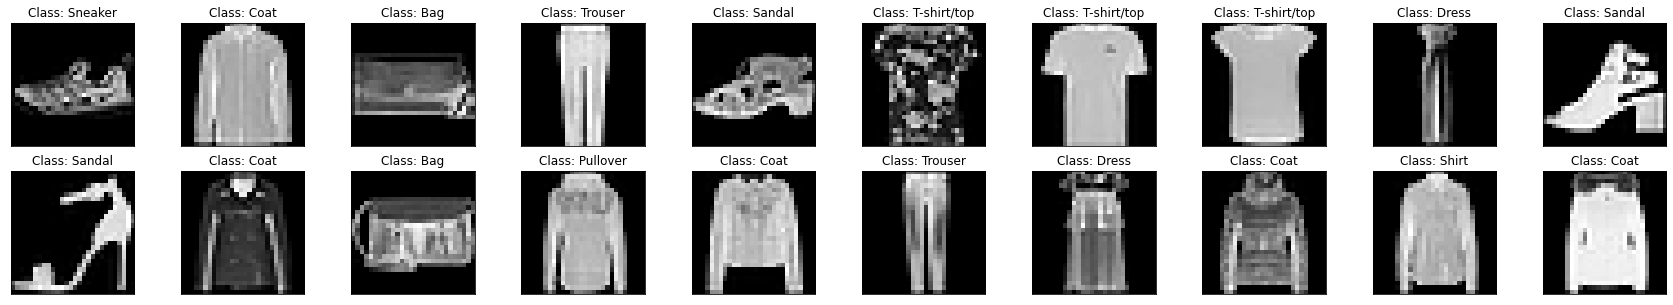

In [4]:
## visualizing images
train_images,train_labels = next(iter(trainloader))
plot_batch(train_images,classes,train_labels,normalize=True)

In [5]:
## CNN model
class FashionNet(nn.Module):
  def __init__(self,conv_dim=32):
    super(FashionNet,self).__init__()
    ## defining layers
    self.conv_1 =  nn.Conv2d(1,conv_dim,3,padding=1)
    self.bnorm_1 = nn.BatchNorm2d(conv_dim)
    self.conv_2 = nn.Conv2d(conv_dim,conv_dim*2,3,padding=1)
    self.bnorm_2 = nn.BatchNorm2d(conv_dim*2)
    self.conv_3 = nn.Conv2d(conv_dim*2,conv_dim*4,3,padding=1)
    self.bnorm_3 = nn.BatchNorm2d(conv_dim*4)
    self.maxpool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(3*3*conv_dim*4,512)
    self.fc2 = nn.Linear(512,10)

  def forward(self,x):
    x = self.conv_1(x)
    # x = self.dropout(x)
    x = self.bnorm_1(x)
    x = F.relu(x)
    x = self.maxpool(x)
    x = self.conv_2(x)
    # x = self.dropout(x)
    x = self.bnorm_2(x)
    x = F.relu(x)
    x = self.maxpool(x)
    x = self.conv_3(x)
    # x = self.dropout(x)
    x = self.bnorm_3(x)
    x = F.relu(x)
    x = self.maxpool(x)
    # x = self.dropout(x)
    x = x.view(x.shape[0],-1) ## flatten
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.log_softmax(self.fc2(x),dim=1)
    return x

model = FashionNet()
model = model.to(device)
print(model)

FashionNet(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [18]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
# model.load_state_dict(torch.load("model_weights.pth"))
train_loss,valid_loss = train(model,trainloader,validloader,optimizer,criterion,10,device)

epoch: 1/10 trainloss: 0.40462 validloss: 0.31003 time: 17.193 sec
Loss decresed: inf -> 0.31003
epoch: 2/10 trainloss: 0.26828 validloss: 0.25944 time: 16.969 sec
Loss decresed: 0.31003 -> 0.25944
epoch: 3/10 trainloss: 0.22395 validloss: 0.27958 time: 16.996 sec
epoch: 4/10 trainloss: 0.19181 validloss: 0.25057 time: 16.851 sec
Loss decresed: 0.25944 -> 0.25057
epoch: 5/10 trainloss: 0.16450 validloss: 0.23466 time: 17.102 sec
Loss decresed: 0.25057 -> 0.23466
epoch: 6/10 trainloss: 0.14224 validloss: 0.27461 time: 17.006 sec
epoch: 7/10 trainloss: 0.12368 validloss: 0.24770 time: 16.870 sec
epoch: 8/10 trainloss: 0.10588 validloss: 0.26075 time: 16.860 sec
epoch: 9/10 trainloss: 0.09594 validloss: 0.27225 time: 16.860 sec
epoch: 10/10 trainloss: 0.08280 validloss: 0.28716 time: 16.989 sec


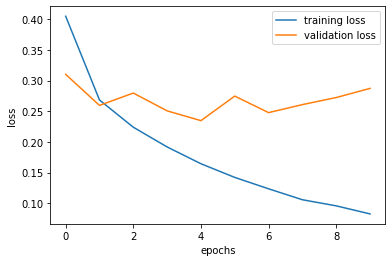

In [19]:
plt.plot(train_loss,label="training loss")
plt.plot(valid_loss,label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [6]:
model.load_state_dict(torch.load("model_weights.pth"))

<All keys matched successfully>

In [8]:
test(model,testloader,optimizer,criterion,device)

testloss: 0.260810 accuracy: 0.914


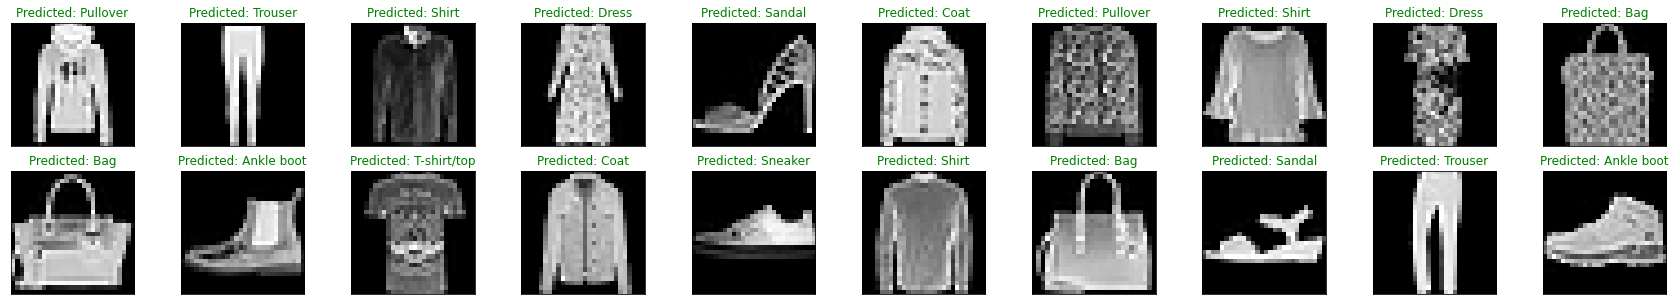

In [9]:
test_images,test_labels = next(iter(testloader))
predict(test_images,classes,test_labels,model,device)